In [1]:
import pandas as pd
import json

from transformers import CamembertTokenizer, CamembertForSequenceClassification, BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
import numpy as np
import evaluate
import torch
from torch.utils.data import DataLoader

In [2]:
torch.cuda.get_device_name(0)
#pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

'NVIDIA GeForce GTX 1080'

In [3]:
train_df = pd.read_csv("../data/train.csv") # chargement des données d'entraînement
train_df = train_df.set_index("id")
train_df.entities = train_df.entities.apply(json.loads) # parsing des entités
train_df.relations = train_df.relations.apply(json.loads) # parsing des relations
train_df.head()

,text,entities,relations
id,,,
181,"Anam Destresse, président de l'ONG ""Ma passion...","[{'id': 0, 'mentions': [{'value': 'accident', ...","[[0, STARTED_IN, 9], [7, IS_LOCATED_IN, 9], [5..."
31669,"À Paris, le 8 avril 2022, l'usine de déodorant...","[{'id': 0, 'mentions': [{'value': 'explosé', '...","[[9, IS_LOCATED_IN, 8], [11, OPERATES_IN, 8], ..."
51470,"En Espagne, dans une région agricole, une cont...","[{'id': 0, 'mentions': [{'value': 'contaminati...","[[7, IS_PART_OF, 8], [9, OPERATES_IN, 1], [0, ..."
51332,Un important incendie a fait des ravages dans ...,"[{'id': 0, 'mentions': [{'value': 'incendie', ...","[[12, IS_IN_CONTACT_WITH, 5], [0, IS_LOCATED_I..."
1131,« Je coule » : onze heures après avoir envoyé ...,"[{'id': 0, 'mentions': [{'value': 'renversé', ...","[[9, IS_LOCATED_IN, 2], [0, START_DATE, 17], [..."


In [4]:
ONTOLOGY_RELATIONS = [
    "HAS_CONTROL_OVER",
    "STARTED_IN",
    "IS_LOCATED_IN",
    "HAS_CATEGORY",
    "IS_PART_OF",
    "INJURED_NUMBER",
    "IS_OF_NATIONALITY",
    "OPERATES_IN",
    "INITIATED",
    "RESIDES_IN",
    "HAS_CONSEQUENCE",
    "IS_COOPERATING_WITH",
    "IS_IN_CONTACT_WITH",
    "IS_OF_SIZE",
    "HAS_QUANTITY",
    "HAS_FOR_LENGTH",
    "IS_BORN_IN",
    "WEIGHS",
    "HAS_FOR_WIDTH",
    "HAS_COLOR",
    "HAS_LATITUDE",
    "IS_REGISTERED_AS",
    "IS_AT_ODDS_WITH",
    "CREATED",
    "HAS_FAMILY_RELATIONSHIP",
    "DEATHS_NUMBER",
    "HAS_FOR_HEIGHT",
    "HAS_LONGITUDE",
    "IS_DEAD_ON",
    "START_DATE",
    "END_DATE",
    "WAS_CREATED_IN",
    "IS_BORN_ON",
    "WAS_DISSOLVED_IN",
    "DIED_IN",
    "GENDER_FEMALE",
    "GENDER_MALE",
]

In [5]:

# Transformer les données en format d'entraînement
# Vous devez transformer ces données en un format où chaque exemple d'entraînement contient une paire d'entités et le contexte, ainsi que la relation correspondante.

training_data = []

for index, entry in train_df.iterrows():
    text = entry["text"]
    entities = entry["entities"]
    relations = entry["relations"]

    ent_type = {}
    for x in entities :
        ent_type[x["id"]] = x["type"]

    for relation in relations:
        entity1_idx = relation[0]
        entity2_idx = relation[2]
        relation_type = relation[1]

        # entity1 = entities[entity1_idx]["value"]
        # entity2 = entities[entity2_idx]["value"]
        entity1 = ent_type[entity1_idx]
        entity2 = ent_type[entity2_idx]

        # Créer l'exemple d'entraînement
        example = {
            "text": text,
            "entity1": entity1,
            "entity2": entity2,
            "relation": relation_type
        }
        training_data.append(example)

# Afficher un exemple de données transformées
print(json.dumps(training_data[0], indent=2))

{
  "text": "Anam Destresse, pr\u00e9sident de l'ONG \"Ma passion\", a \u00e9t\u00e9 bless\u00e9 dans un accident. Le 30 juin 2022, un accident de circulation s'est produit entre une moto et un bus sur l'autoroute de Saint-Marin en Italie. Le bus, qui transportait 20 passagers, appartenait \u00e0 l'ONG. Lors de l'accident, les panneaux de signalisation ont \u00e9t\u00e9 compl\u00e8tement endommag\u00e9s et le garde du corps a \u00e9t\u00e9 bless\u00e9. Au total, deux passagers sont morts sur le coup. Anam Destresse, qui faisait partie des bless\u00e9s, a \u00e9t\u00e9 transport\u00e9 en h\u00e9licopt\u00e8re jusqu'\u00e0 l'h\u00f4pital. Le conducteur de la moto a \u00e9t\u00e9 retrouv\u00e9 mort en dessous du bus. Il conduisait sans permis et en \u00e9tat d'ivresse.",
  "entity1": "ACCIDENT",
  "entity2": "PLACE",
  "relation": "STARTED_IN"
}


In [6]:
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
relation_map = {relation: i for i, relation in enumerate(ONTOLOGY_RELATIONS)}

# Fonction pour formater les entrées
def format_input(example):
    text = example['text']
    entities = example['entities']
    relations = example['relations']

    formatted_inputs = []
    labels = []

    for relation in relations:
        entity1_idx = relation[0]
        entity2_idx = relation[2]
        relation_type = relation[1]

        entity1 = entities[entity1_idx]['type']
        entity2 = entities[entity2_idx]['type']

        # Créer l'exemple d'entraînement
        input_text = f"[CLS] {entity1} {relation_type} {entity2} [SEP] {text} [SEP]"
        inputs = tokenizer(input_text, truncation=True, padding='max_length', max_length=512)
        inputs['labels'] = relation_map[relation_type]

        formatted_inputs.append(inputs)
        labels.append(relation_map[relation_type])

    return formatted_inputs, labels

# Appliquer la fonction de formatage aux datasets
formatted_data = []
labels = []

for _, row in train_df.iterrows():
    formatted_inputs, row_labels = format_input(row)
    formatted_data.extend(formatted_inputs)
    labels.extend(row_labels)

# Convertir les données formatées en Dataset
dataset = Dataset.from_dict({
    'input_ids': [item['input_ids'] for item in formatted_data],
    'attention_mask': [item['attention_mask'] for item in formatted_data],
    'labels': labels
})

# Séparer les données en train et test
dataset_dict = dataset.train_test_split(test_size=0.1)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
print(relation_map)

{'HAS_CONTROL_OVER': 0, 'STARTED_IN': 1, 'IS_LOCATED_IN': 2, 'HAS_CATEGORY': 3, 'IS_PART_OF': 4, 'INJURED_NUMBER': 5, 'IS_OF_NATIONALITY': 6, 'OPERATES_IN': 7, 'INITIATED': 8, 'RESIDES_IN': 9, 'HAS_CONSEQUENCE': 10, 'IS_COOPERATING_WITH': 11, 'IS_IN_CONTACT_WITH': 12, 'IS_OF_SIZE': 13, 'HAS_QUANTITY': 14, 'HAS_FOR_LENGTH': 15, 'IS_BORN_IN': 16, 'WEIGHS': 17, 'HAS_FOR_WIDTH': 18, 'HAS_COLOR': 19, 'HAS_LATITUDE': 20, 'IS_REGISTERED_AS': 21, 'IS_AT_ODDS_WITH': 22, 'CREATED': 23, 'HAS_FAMILY_RELATIONSHIP': 24, 'DEATHS_NUMBER': 25, 'HAS_FOR_HEIGHT': 26, 'HAS_LONGITUDE': 27, 'IS_DEAD_ON': 28, 'START_DATE': 29, 'END_DATE': 30, 'WAS_CREATED_IN': 31, 'IS_BORN_ON': 32, 'WAS_DISSOLVED_IN': 33, 'DIED_IN': 34, 'GENDER_FEMALE': 35, 'GENDER_MALE': 36}


In [ ]:
# # Charger le tokenizer et le modèle BERT
# tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
# model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=len(ONTOLOGY_RELATIONS))
# relation_map = {relation: i for i, relation in enumerate(ONTOLOGY_RELATIONS)}

# # Fonction de prétraitement des données
# def preprocess_function(examples):
#     texts = examples['text']
#     entity1 = examples['entity1']
#     entity2 = examples['entity2']
#     relations = examples['relation']

#     # Tokenization
#     inputs = tokenizer(texts, padding="max_length", truncation=True, return_tensors="pt")
#     labels = [relation_map[r] for r in relations]

#     inputs['labels'] = labels
#     return inputs

# # Créer un Dataset Hugging Face
# # tmp = pd.DataFrame(training_data)
# # tmp = tmp.iloc[:2500]
# dataset = Dataset.from_pandas(pd.DataFrame(training_data))
# tokenized_datasets = dataset.map(preprocess_function, batched=True)
# tokenized_datasets = tokenized_datasets.train_test_split(test_size=0.1)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/31469 [00:00<?, ? examples/s]

In [8]:
len(training_data)

31469

In [11]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 28322
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3147
    })
})

In [ ]:
# from datasets import DatasetDict

# # Vérifier les types de données
# for feature in ["input_ids", "attention_mask"]:
#     assert all(isinstance(example[feature], list) for example in tokenized_datasets["train"]), f"La colonne {feature} doit contenir des listes."

# # Vérifier les dimensions
# for example in tokenized_datasets["train"]:
#     assert len(example["input_ids"]) == len(example["attention_mask"]), "Les dimensions de input_ids et attention_mask doivent être les mêmes."
#     assert isinstance(example["labels"], (int, list)), "Les labels doivent être des entiers ou des listes d'entiers."

# # Vérifier les valeurs
# for example in tokenized_datasets["train"]:
#     assert all(isinstance(id, int) and id >= 0 for id in example["input_ids"]), "Les input_ids doivent être des entiers non négatifs."
#     assert all(isinstance(mask, int) and mask in [0, 1] for mask in example["attention_mask"]), "Les attention_mask doivent contenir des 0 et des 1."
#     if isinstance(example["labels"], int):
#         assert example["labels"] >= 0, "Les labels doivent être des entiers non négatifs."
#     else:
#         assert all(isinstance(label, int) and label >= 0 for label in example["labels"]), "Les labels doivent être des entiers non négatifs."

# print("Le dataset est bien formaté pour être utilisé par BERT.")


In [12]:
print(f"Utilisation de l'appareil : {torch.cuda.get_device_name(0)}")

Utilisation de l'appareil : NVIDIA GeForce GTX 1080


In [ ]:
model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=len(ONTOLOGY_RELATIONS))

In [ ]:
# Définir les arguments d'entraînement
training_args = TrainingArguments(
    output_dir='../results',
    eval_strategy="steps",
    evaluation_steps=500,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='../logs',
    logging_steps=100,
    report_to="none"
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialiser le Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics
)

# Entraîner le modèle
train_result = trainer.train()


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1000,2.625300,2.504645,0.290753,0.130989,0.084537,0.290753
2000,2.489800,2.465911,0.294725,0.141953,0.098405,0.294725
3000,2.456500,2.450470,0.294725,0.145345,0.129178,0.294725


c:\Users\thebo\Desktop\TextMine25\env_textmine\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thebo\Desktop\TextMine25\env_textmine\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thebo\Desktop\TextMine25\env_textmine\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [19]:
# Compute train results
metrics = train_result.metrics
max_train_samples = len(tokenized_datasets["train"])
metrics["train_samples"] = min(max_train_samples, len(tokenized_datasets["train"]))

# Save train results
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)

# Compute evaluation results
metrics = trainer.evaluate()
max_val_samples = len(tokenized_datasets["test"])
metrics["eval_samples"] = min(max_val_samples, len(tokenized_datasets["test"]))

# Save evaluation results
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** train metrics *****
  epoch                    =        2.0
  total_flos               = 12341704GF
  train_loss               =     2.5207
  train_runtime            = 1:45:06.36
  train_samples            =      25175
  train_samples_per_second =      7.984
  train_steps_per_second   =      0.499
***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.2928
  eval_f1                 =     0.1453
  eval_loss               =     2.4496
  eval_precision          =     0.1283
  eval_recall             =     0.2928
  eval_runtime            = 0:04:13.77
  eval_samples            =       6294
  eval_samples_per_second =     24.802
  eval_steps_per_second   =      1.553


c:\Users\thebo\Desktop\TextMine25\env_textmine\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


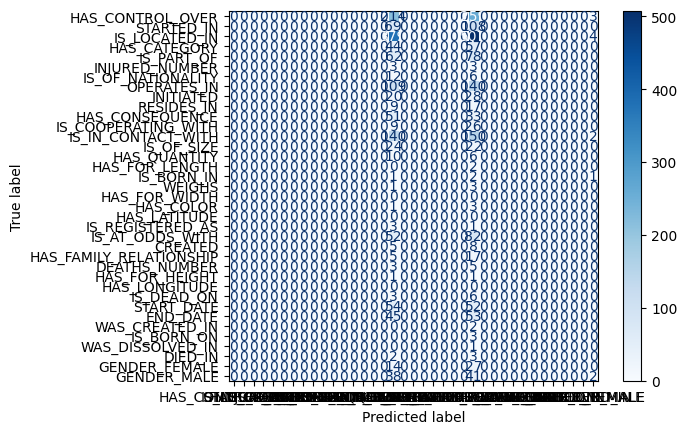

Rapport par classe :
                      Class  Precision    Recall  F1-Score  Support
0          HAS_CONTROL_OVER   0.000000  0.000000  0.000000      476
1                STARTED_IN   0.000000  0.000000  0.000000      177
2             IS_LOCATED_IN   0.000000  0.000000  0.000000      890
3              HAS_CATEGORY   0.000000  0.000000  0.000000      101
4                IS_PART_OF   0.000000  0.000000  0.000000      140
5            INJURED_NUMBER   0.000000  0.000000  0.000000        6
6         IS_OF_NATIONALITY   0.000000  0.000000  0.000000       18
7               OPERATES_IN   0.000000  0.000000  0.000000      249
8                 INITIATED   0.000000  0.000000  0.000000       48
9                RESIDES_IN   0.000000  0.000000  0.000000       26
10          HAS_CONSEQUENCE   0.000000  0.000000  0.000000       84
11      IS_COOPERATING_WITH   0.000000  0.000000  0.000000       35
12       IS_IN_CONTACT_WITH   0.000000  0.000000  0.000000      292
13               IS_OF_SIZE

In [ ]:
def evaluate_per_class(model, dataset, relation_map):
    model = model.to(device)
    model.eval()
    predictions, labels = [], []

    # Process the dataset in batches
    batch_size = 16
    for i in range(0, len(dataset), batch_size):
        batch = dataset.select(range(i, min(i + batch_size, len(dataset))))

        inputs = {
            'input_ids': torch.tensor(batch['input_ids']).to(device),
            'attention_mask': torch.tensor(batch['attention_mask']).to(device),
            'labels': torch.tensor(batch['labels']).to(device)
        }
        
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
        labels.extend(inputs['labels'].cpu().numpy())

    precision, recall, f1, support = precision_recall_fscore_support(labels, predictions, labels=list(relation_map.values()), average=None, zero_division=0)

    # Create a DataFrame for better readability
    report_df = pd.DataFrame({
        'Class': list(relation_map.keys()),
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })


     # Generate confusion matrix
    plt.figure(figsize=(20, 8))
    cm = confusion_matrix(labels, predictions, labels=list(relation_map.values()))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(relation_map.keys()))
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    return report_df


report_df = evaluate_per_class(model, tokenized_datasets["test"], relation_map)
print("Rapport par classe :")
print(report_df)

`Les résultats sont mauvais... J'entraine sur les types pour chaque EN, peut-être que je devrais utiliser directement le mot (ou GN) de l'EN`

data = [
    {
        "text": "[E1]Anam Destresse[/E1] was injured in an accident involving a [E2]bus[/E2].",
        "label": "IS_LOCATED_IN"
    },
    {
        "text": "The [E1]bus[/E1] was traveling on the [E2]highway[/E2].",
        "label": "STARTED_IN"
    },
    # Add more examples...
]